# 12wk-1: 선인장 이미지 분류

최규빈  
2024-12-03

<a href="https://colab.research.google.com/github/guebin/MP2024/blob/main/posts/12wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-z5Wh8S9Whc_lGehzJvMSit&si=BcmhgMK95Gadjbfl>

# 2. imports

In [1]:
import numpy as np
import pandas as pd 
import zipfile
import os
import PIL.Image
import matplotlib.pyplot as plt
#---#
import datasets
import transformers
import torchvision.transforms
import evaluate
import torch

/home/cgb3/anaconda3/envs/hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

# 3. Kaggle

## A. ref

ref: <https://www.kaggle.com/c/aerial-cactus-identification>

## B. 압축해제

In [2]:
with zipfile.ZipFile('aerial-cactus-identification.zip', 'r') as z:
    z.extractall('./data')

In [3]:
with zipfile.ZipFile('./data/test.zip', 'r') as z_test:
    z_test.extractall('./data')    
with zipfile.ZipFile('./data/train.zip', 'r') as z_train:
    z_train.extractall('./data')

## C. 데이터 살펴보기

In [4]:
train_csv = pd.read_csv("./data/train.csv")
train_csv

-   train에는 이미지에 해당하는 라벨이 존재

In [5]:
test_csv = pd.read_csv("./data/sample_submission.csv")
test_csv

-   test에는 이미지에 해당하는 라벨이 존재하지 않음.
-   우리의 목표: 확률값을 잘 추정해서 `sample_submission`의
    `has_cactus`열에 대입하고 그 결과를 캐글에 제출

# 4. Logits의 이해

## A. 로짓의 의미

`-` 로짓의 이해: 클래스가 2개인 자료에 대한 분류문제를 푼다고 하자.
8개의 observation/examples 에 대한 로짓값이 아래와 같다고 하자.

In [6]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
logits

로짓값은 일반적으로 $(n,k)$의 차원을 가지며 여기에서 $n$은 observation의
숫자, $k$는 클래스의 숫자를 의미한다. 이 예제의 경우는 $n=8$, $k=2$인
경우이다.

여기에서 각 observation에 대한 로짓값이 의미하는 바를 살펴보면 아래와
같다.

1.  첫 번째 관측값 (`[2.7346244, -3.1177292]`):

-   첫 번째 클래스에 대한 확신 정도: `2.7346244`
-   두 번째 클래스에 대한 확신 정도: `-3.1177292`

1.  두 번째 관측값 (`[2.7103324,  -3.1362345]`):

-   첫 번째 클래스에 대한 확신 정도: `2.7103324`
-   두 번째 클래스에 대한 확신 정도: `-3.1362345`

…

1.  마지막에서 두번째 관측값 (\[`0.0657177`, `-0.0930362`\]):

-   첫 번째 클래스에 대한 확신 정도: `0.0657177`
-   두 번째 클래스에 대한 확신 정도: `-0.0930362`

1.  마지막 관측값 (\[`-2.7668718`, `3.0918367`\]):

-   첫 번째 클래스에 대한 확신 정도: `-2.7668718`
-   두 번째 클래스에 대한 확신 정도: `3.0918367`

## B. 로짓 $\to$ 예측클래스

`-` 로짓 $\to$ 예측클래스의 과정을 살펴보자.

1.  첫 번째 관측값: $2.7346244 > -3.1177292$ $\Rightarrow$ 첫 번째
    클래스로 예측

2.  두 번째 관측값: $2.7103324 > -3.1362345$ $\Rightarrow$ 첫 번째
    클래스로 예측

…

1.  마지막에서 두번째 관측값: $0.0657177 > -0.0930362$ $\Rightarrow$ 첫
    번째 클래스로 예측

2.  마지막 관측값: $-2.7668718 < 3.0918367$ $\Rightarrow$ 두 번째
    클래스로 예측

In [7]:
logits

In [8]:
for u in logits:
    u1, u2 = u 
    if u1 > u2: 
        prediction = 0 
    else: 
        prediction = 1 
    print(prediction)

0
0
0
0
0
0
0
1

`-` 이것은 아래를 이용하여 구할수도 있다.

In [9]:
logits.argmax(axis=1)

## C. 로짓 $\to$ 예측확률

`-` 로짓 $\to$ 예측확률의 과정을 살펴보자.

${\boldsymbol u}=\begin{bmatrix} u_1 & \dots & u_k\end{bmatrix}$를
고정된 observation에 대한 logits값 이라고 하자. 이때 각 클래스에 속할
확률값은 아래와 같이 구한다.

$$\text{prob} =\left[\frac{\exp(u_1)}{\exp(u_1)+\dots+\exp(u_k)}, \cdots,  \frac{\exp(u_k)}{\exp(u_1)+\dots+\exp(u_k)}\right]$$

In [10]:
logits

In [11]:
for u in logits:
    u1,u2 = u
    p1 = np.exp(u1) / (np.exp(u1)+np.exp(u2))
    p2 = np.exp(u2) / (np.exp(u1)+np.exp(u2))
    prediction_scores = [p1,p2]
    print(prediction_scores)

[0.9971351022231982, 0.0028648977768018545]
[0.9971185237682113, 0.0028814762317887605]
[0.9969773496339113, 0.0030226503660887583]
[0.9971058336243687, 0.0028941663756314024]
[0.997035364944602, 0.0029646350553980375]
[0.9971274386623321, 0.002872561337667959]
[0.5396053294830294, 0.4603946705169706]
[0.0028468010295870897, 0.997153198970413]

`-` 이 확률은 아래를 통하여 구할수도 있다.

In [12]:
torch.tensor(logits).softmax(dim=1)

# 5. 평가지표

## A. accuracy 계산

`-` accuracy의 계산: `logits`와 `labels`가 아래와 같이 주어졌다고 하자.

In [13]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
references = labels = np.array([0,0,0,0,0,0,1,1])

In [14]:
predictions = logits.argmax(axis=1)
predictions

In [15]:
references

accuracy는 아래와 같이 계산할 수 있다.

In [16]:
7/8

In [17]:
(predictions == references).sum() / 8

In [18]:
(predictions == references).mean()

이걸 아래와 같이 계산할 수도 있다.

In [19]:
acc = evaluate.load("accuracy")
acc.compute(predictions = predictions, references= references)

## B. recall 계산

`-` 경우에 따라서 1을 얼마나 더 잘맞추는지 알고 싶은 경우도 있다.

$$\text{recall}= \frac{\text{실제 라벨이 1인 관측치 중 올바르게 예측된 관측치수}}{\text{실제 라벨이 1인 관측치 수}}$$

In [20]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
references = labels = np.array([0,0,0,0,0,0,1,1])

In [21]:
predictions = logits.argmax(axis=1)
predictions

In [22]:
(predictions[references == 1]==1).mean() # recall 

이것을 아래와 같이 구할수도 있다.

In [23]:
rec = evaluate.load("recall")
rec.compute(predictions = predictions, references = references)

## C. auc 계산

`-` accuracy 이외의 평가지표들

-   <https://guebin.github.io/MP2023/posts/12wk-46.html> // 시험에는 X

`-` AUC: 클래스간의 불균형이 있을때 유의미한 평가지표

In [24]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
references = labels = np.array([0,0,0,0,0,0,1,1])

In [25]:
probabilities = torch.tensor(logits).softmax(dim=1).numpy()
prediction_scores = probabilities[:,1]
prediction_scores

-   확률 0.4 이상부터는 1로 판단한다면? $\to$ 다 맞춘거아니야?

In [26]:
roc_auc = evaluate.load("roc_auc")
roc_auc.compute(prediction_scores=prediction_scores, references=references)

`# 예제1` – 시각화

{'accuracy': 0.875}
{'recall': 0.5}
{'roc_auc': 1.0}

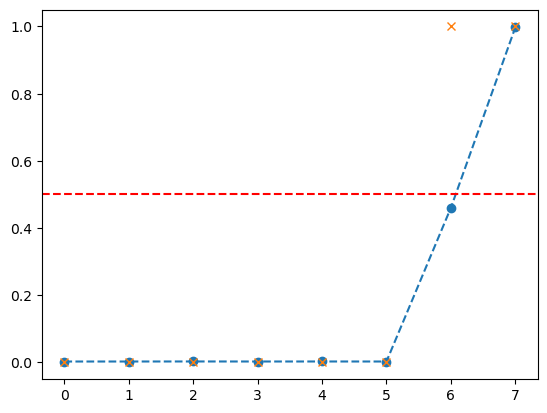

In [27]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
references = labels = np.array([0,0,0,0,0,0,1,1])
probabilities = torch.tensor(logits).softmax(dim=1).numpy()
prediction_scores = probabilities[:,1]
plt.plot(prediction_scores,'--o')
plt.plot(labels,'x')
plt.axhline(y=0.5,color='red',linestyle='--')
acc = evaluate.load("accuracy")
rec = evaluate.load("recall")
roc_auc = evaluate.load("roc_auc")
print(acc.compute(predictions=predictions,references=references))
print(rec.compute(predictions=predictions,references=references))
print(roc_auc.compute(prediction_scores=prediction_scores,references=references))

`# 예제2` – 시각화

{'accuracy': 0.875}
{'recall': 0.5}
{'roc_auc': 0.5833333333333333}

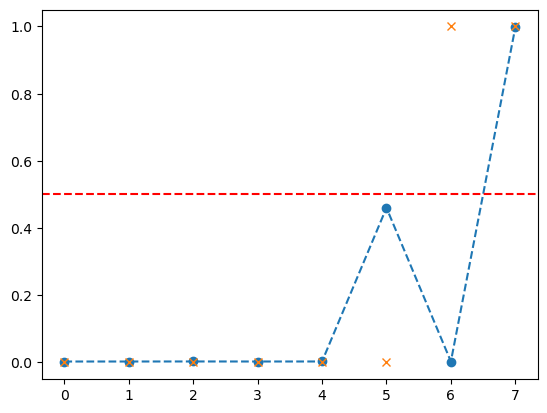

In [28]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 0.0657177, -0.0930362],
     [ 2.7398622, -3.1098123],
     [-2.7668718,  3.0918367]]
)
references = labels = np.array([0,0,0,0,0,0,1,1])
probabilities = torch.tensor(logits).softmax(dim=1).numpy()
prediction_scores = probabilities[:,1]
plt.plot(prediction_scores,'--o')
plt.plot(labels,'x')
plt.axhline(y=0.5,color='red',linestyle='--')
acc = evaluate.load("accuracy")
rec = evaluate.load("recall")
roc_auc = evaluate.load("roc_auc")
print(acc.compute(predictions=predictions,references=references))
print(rec.compute(predictions=predictions,references=references))
print(roc_auc.compute(prediction_scores=prediction_scores,references=references))

# 6. 분석

`-` `train.csv`를 pandas로

In [29]:
train_csv = pd.read_csv("./data/train.csv")
train_csv

In [30]:
test_csv = pd.read_csv("./data/sample_submission.csv")
test_csv

## A. 예쁜(?) 정석 코드

*Step1: Data*

In [31]:
ctx_train = datasets.Dataset.from_pandas(train_csv)
ctx_test = datasets.Dataset.from_pandas(test_csv).remove_columns(['has_cactus'])

In [32]:
ctx_train = ctx_train.map(lambda example: {'path': "./data/train/" + example['id']})
ctx_test = ctx_test.map(lambda example: {'path': "./data/test/" + example['id']})

Map: 100%|██████████| 4000/4000 [00:00<00:00, 86647.98 examples/s]

In [33]:
ctx = datasets.DatasetDict({
    'train':ctx_train,
    'test':ctx_test
})
ctx

In [34]:
compose = torchvision.transforms.Compose([
    lambda path: PIL.Image.open(path),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224,224))
])
def w_trans(examples):
    # train: examples = {'id':[xx,xxx,....], 'has_cactus':[yy,yyy,...], 'path':[zz,zzz,...]}
    # train: examples = {'id':[xx,xxx,....], 'path':[zz,zzz,...]}
    dct = dict()
    dct['pixel_values'] = torch.stack(list(map(compose, examples['path'])))
    try: 
        dct['labels']= torch.tensor(examples['has_cactus'])
    except:
        pass
    return dct 

In [35]:
ctx = ctx.with_transform(w_trans)
ctx 

In [36]:
ctx['train'][:2]
#ctx['test'][:2]

*Step2: Model*

In [37]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    num_labels=2,
    ignore_mismatched_sizes=True,
)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

*Step3: Train*

In [44]:
# single_batch = [ctx['train'][0],ctx['train'][1]]
# single_batch # [{'pixel_values':xx, 'labels':yy},{'pixel_values':xxx, 'labels':yyy}]
# data_collator = transformers.DefaultDataCollator()
# data_collator(single_batch) # [{'pixel_values':xx, 'labels':yy},{'pixel_values':xxx, 'labels':yyy}] --> {'pixel_values':[xx,xxx], 'labels':[yy,yyy]}
# model.to("cpu")
# model(**data_collator(single_batch))

In [45]:
data_collator = transformers.DefaultDataCollator()
data_collator

In [47]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits,axis=1)
    predictions_scores = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
    acc = evaluate.load("accuracy")
    rec = evaluate.load("recall")
    roc_auc = evaluate.load("roc_auc")
    dct1 = acc.compute(predictions = predictions, references = labels) # {'accuracy':???}
    dct2 = rec.compute(predictions = predictions, references = labels) # {'recall':???}
    dct3 = roc_auc.compute(prediction_scores = predictions_scores, references = labels) # {'roc_auc':???}
    return dct1|dct2|dct3# {'accuracy':???, 'recall':???, 'roc_auc':???}

In [50]:
training_args = transformers.TrainingArguments(
    output_dir="asdf",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="none"
)
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ctx["train"].select(range(1000)),
    eval_dataset=ctx["train"].select(range(1000,1500)),
    compute_metrics=compute_metrics,
)
trainer.train()

*Step4: Prediction*

In [54]:
out = trainer.predict(ctx['test'])
out

In [60]:
logits = out.predictions
has_cactus = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
has_cactus

In [61]:
test_csv['has_cactus']= has_cactus
test_csv

*Step1 ~ Step4*

In [134]:
train_csv = pd.read_csv("./data/train.csv")
test_csv = pd.read_csv("./data/sample_submission.csv")
#---#
# Step1: Data
ctx_train = datasets.Dataset.from_pandas(train_csv)
ctx_test = datasets.Dataset.from_pandas(test_csv).remove_columns(['has_cactus'])
ctx_train = ctx_train.map(lambda example: {'path': "./data/train/" + example['id']})
ctx_test = ctx_test.map(lambda example: {'path': "./data/test/" + example['id']})
ctx = datasets.DatasetDict({
    'train':ctx_train,
    'test':ctx_test
})
compose = torchvision.transforms.Compose([
    lambda path: PIL.Image.open(path),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224,224))
])
def w_trans(examples):
    # train: examples = {'id':[xx,xxx,....], 'has_cactus':[yy,yyy,...], 'path':[zz,zzz,...]}
    # train: examples = {'id':[xx,xxx,....], 'path':[zz,zzz,...]}
    dct = dict()
    dct['pixel_values'] = torch.stack(list(map(compose, examples['path'])))
    try: 
        dct['labels']= torch.tensor(examples['has_cactus'])
    except:
        pass
    return dct 
ctx = ctx.with_transform(w_trans)
# Step2: Model
model = transformers.AutoModelForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    num_labels=2,
    ignore_mismatched_sizes=True,
)
# Step3: Train
data_collator = transformers.DefaultDataCollator()
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits,axis=1)
    predictions_scores = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
    acc = evaluate.load("accuracy")
    rec = evaluate.load("recall")
    roc_auc = evaluate.load("roc_auc")
    dct1 = acc.compute(predictions = predictions, references = labels) # {'accuracy':???}
    dct2 = rec.compute(predictions = predictions, references = labels) # {'recall':???}
    dct3 = roc_auc.compute(prediction_scores = predictions_scores, references = labels) # {'roc_auc':???}
    return dct1|dct2|dct3# {'accuracy':???, 'recall':???, 'roc_auc':???}
training_args = transformers.TrainingArguments(
    output_dir="asdf",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc",
    push_to_hub=False,
    report_to="none"
)
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ctx["train"].select(range(1000)),
    eval_dataset=ctx["train"].select(range(1000,1500)),
    compute_metrics=compute_metrics,
)
trainer.train()
# Step4: Prediction
out = trainer.predict(ctx['test'])
logits = out.predictions
has_cactus = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
test_csv['has_cactus']= has_cactus

Map: 100%|██████████| 4000/4000 [00:00<00:00, 87028.23 examples/s]
Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

## B. 자유로운 코드

*Step1: Datasets*

In [94]:
train_csv = pd.read_csv("./data/train.csv")
test_csv = pd.read_csv("./data/sample_submission.csv")
train_csv2 = pd.read_csv("./data/train.csv")
test_csv2 = pd.read_csv("./data/sample_submission.csv")

In [95]:
train_csv2['path'] = ['./data/train/'+l for l in train_csv.id]
test_csv2['path'] = ['./data/test/'+l for l in test_csv.id]
train_csv2 = train_csv2.loc[:,['has_cactus','path']]
test_csv2 = test_csv2.loc[:,['path']]

In [98]:
ctx = datasets.DatasetDict(
    {
        'train': datasets.Dataset.from_pandas(train_csv2),
        'test':datasets.Dataset.from_pandas(test_csv2)
    }
)
ctx

*Step2~3 과정의 간보기*

In [108]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    num_labels=2,
    ignore_mismatched_sizes=True,
)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

In [125]:
single_batch =  [ctx['train'][0], ctx['train'][1]]
single_batch

In [110]:
compose = torchvision.transforms.Compose([
    lambda path: PIL.Image.open(path),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224,224))
])

In [128]:
def collate_fn(single_batch):
    dct = dict()
    dct['pixel_values'] = torch.stack([compose(o['path']) for o in single_batch])
    try: 
        dct['labels'] = torch.tensor([o['has_cactus'] for o in single_batch])
    except:
        pass
    return dct 

In [130]:
model(**collate_fn(single_batch))

*Step1~4*

In [132]:
train_csv = pd.read_csv("./data/train.csv")
test_csv = pd.read_csv("./data/sample_submission.csv")
train_csv2 = pd.read_csv("./data/train.csv")
test_csv2 = pd.read_csv("./data/sample_submission.csv")
#---#
# Step1: Data
train_csv2['path'] = ['./data/train/'+l for l in train_csv.id]
test_csv2['path'] = ['./data/test/'+l for l in test_csv.id]
train_csv2 = train_csv2.loc[:,['has_cactus','path']]
test_csv2 = test_csv2.loc[:,['path']]
ctx = datasets.DatasetDict(
    {
        'train': datasets.Dataset.from_pandas(train_csv2),
        'test':datasets.Dataset.from_pandas(test_csv2)
    }
)
# Step2: Model
model = transformers.AutoModelForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    num_labels=2,
    ignore_mismatched_sizes=True,
)
# Step3: Train
def collate_fn(single_batch):
    dct = dict()
    dct['pixel_values'] = torch.stack([compose(o['path']) for o in single_batch])
    try: 
        dct['labels'] = torch.tensor([o['has_cactus'] for o in single_batch])
    except:
        pass
    return dct 
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits,axis=1)
    predictions_scores = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
    acc = evaluate.load("accuracy")
    rec = evaluate.load("recall")
    roc_auc = evaluate.load("roc_auc")
    dct1 = acc.compute(predictions = predictions, references = labels) # {'accuracy':???}
    dct2 = rec.compute(predictions = predictions, references = labels) # {'recall':???}
    dct3 = roc_auc.compute(prediction_scores = predictions_scores, references = labels) # {'roc_auc':???}
    return dct1|dct2|dct3# {'accuracy':???, 'recall':???, 'roc_auc':???}
training_args = transformers.TrainingArguments(
    output_dir="asdf",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc",
    push_to_hub=False,
    report_to="none"
)
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=ctx["train"].select(range(1000)),
    eval_dataset=ctx["train"].select(range(1000,1500)),
    compute_metrics=compute_metrics,
)
trainer.train()
# Step4: Prediction
out = trainer.predict(ctx['test'])
logits = out.predictions
has_cactus = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
test_csv['has_cactus']= has_cactus

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

# A1. 작년강의노트

<https://guebin.github.io/MP2023/> – tabular data 분석 위주의 수업